<a href="https://colab.research.google.com/github/thdefn/AIproj2022/blob/master/cnn_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CNN 증강 안한 버전
모델, 히스토리 저장 링크
https://drive.google.com/drive/folders/1pTTZI_bfVOVXptYJ-GdtdU5HMW5geO0p?usp=sharing


In [ ]:
import numpy as np
import pandas as pd

from tensorflow import keras

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization 
from tensorflow.keras.utils import to_categorical

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

import seaborn as sns
import os
import glob
import plotly.graph_objects as go
import cv2
from PIL import Image
from PIL import ImageFile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tqdm import tqdm

In [ ]:
root_dir = '../input/intel-mobileodt-cervical-cancer-screening'
train_dir = os.path.join(root_dir,'train', 'train')

type1_dir = os.path.join(train_dir, 'Type_1')
type2_dir = os.path.join(train_dir, 'Type_2')
type3_dir = os.path.join(train_dir, 'Type_3')

train_type1_files = glob.glob(type1_dir+'/*.jpg')
train_type2_files = glob.glob(type2_dir+'/*.jpg')
train_type3_files = glob.glob(type3_dir+'/*.jpg')


added_type1_files  =  glob.glob(os.path.join(root_dir, "additional_Type_1_v2", "Type_1")+'/*.jpg')
added_type2_files  =  glob.glob(os.path.join(root_dir, "additional_Type_2_v2", "Type_2")+'/*.jpg')
added_type3_files  =  glob.glob(os.path.join(root_dir, "additional_Type_3_v2", "Type_3")+'/*.jpg')


type1_files = train_type1_files + added_type1_files
type2_files = train_type2_files + added_type2_files
type3_files = train_type3_files + added_type3_files

print(f'''Type 1 files for training: {len(type1_files)} 
Type 2 files for training: {len(type2_files)}
Type 3 files for training: {len(type3_files)}''' )

Type 1 files for training: 1441 
Type 2 files for training: 4348
Type 3 files for training: 2426


In [ ]:
files = {'filepath': type1_files + type2_files + type3_files,
          'label': ['Type 1']* len(type1_files) + ['Type 2']* len(type2_files) + ['Type 3']* len(type3_files)}

files_df = pd.DataFrame(files).sample(frac=1, random_state= 1).reset_index(drop=True)
files_df

,filepath,label
0,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
1,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
2,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
3,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
4,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
...,...,...
8210,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
8211,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
8212,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
8213,../input/intel-mobileodt-cervical-cancer-scree...,Type 2


In [ ]:
bad_files = []
for path in tqdm(files_df['filepath'].values):
    try:
        img = Image.open(path)
    except:
        index = files_df[files_df['filepath']==path].index.values[0]
        bad_files.append(index)

100%|██████████| 8215/8215 [02:17<00:00, 59.59it/s]


In [ ]:
bad_files
files_df.drop(bad_files, inplace=True)
files_df

,filepath,label
0,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
1,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
2,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
3,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
4,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
...,...,...
8210,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
8211,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
8212,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
8213,../input/intel-mobileodt-cervical-cancer-scree...,Type 2


In [ ]:
t = ImageDataGenerator(rescale=1./ 255, rotation_range=0.3, zoom_range=0.3)

t_gen = t.flow_from_dataframe(files_df,x_col='filepath', y_col='label', target_size = (128, 128),batch_size=16,class_mode='categorical', color_mode='rgb', subset='training')

Found 8212 validated image filenames belonging to 3 classes.


In [ ]:
#train_df, valid_df = train_test_split(files_df, test_size = 0.2, stratify = files_df['label'], random_state = 1234)
k = ImageDataGenerator(rescale=1./ 255, validation_split=0.2)
t_nongen = k.flow_from_dataframe(files_df, x_col='filepath', y_col='label', target_size = (128, 128), class_mode='categorical', color_mode='rgb', subset='training')
v_nongen = k.flow_from_dataframe(files_df, x_col='filepath', y_col='label', target_size = (128, 128), class_mode='categorical', color_mode='rgb', subset='validation')

Found 6570 validated image filenames belonging to 3 classes.
Found 1642 validated image filenames belonging to 3 classes.


In [ ]:
cnn = Sequential([
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal', input_shape=(128,128,3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(32, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(64, kernel_initializer='random_normal'),
    Activation('relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
    
])

cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        18464     
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        1

2022-11-25 12:07:30.423855: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
cnn.compile(
    'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [ ]:
general = cnn.fit(t_nongen, validation_data= v_nongen, epochs= 10, verbose=1)
cnn.save('CNN_vernongen1.h5')

2022-11-25 12:07:41.372762: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
206/206 [==============================] - 2617s 13s/step - loss: 1.0037 - accuracy: 0.5253 - val_loss: 0.9818 - val_accuracy: 0.5305
Epoch 2/10
206/206 [==============================] - 2566s 12s/step - loss: 0.9742 - accuracy: 0.5381 - val_loss: 0.9528 - val_accuracy: 0.5353
Epoch 3/10
206/206 [==============================] - 2603s 13s/step - loss: 0.9679 - accuracy: 0.5432 - val_loss: 0.9591 - val_accuracy: 0.5195
Epoch 4/10
206/206 [==============================] - 2596s 13s/step - loss: 0.9538 - accuracy: 0.5400 - val_loss: 0.9638 - val_accuracy: 0.5250
Epoch 5/10
206/206 [==============================] - 2592s 13s/step - loss: 0.9362 - accuracy: 0.5470 - val_loss: 0.9265 - val_accuracy: 0.5305
Epoch 6/10
206/206 [==============================] - 2519s 12s/step - loss: 0.9113 - accuracy: 0.5530 - val_loss: 0.9186 - val_accuracy: 0.5457
Epoch 7/10
206/206 [==============================] - 2561s 12s/step - loss: 0.8931 - accuracy: 0.5612 - val_loss: 0.9153 - val_ac

In [ ]:
general.history

{'loss': [1.003749966621399,
  0.974226176738739,
  0.9679051041603088,
  0.9538061618804932,
  0.9362174868583679,
  0.9113044738769531,
  0.8931166529655457,
  0.863330066204071,
  0.8307437896728516,
  0.8002455234527588],
 'accuracy': [0.5252663493156433,
  0.5380517244338989,
  0.5432267785072327,
  0.5400304198265076,
  0.5470319390296936,
  0.5529680252075195,
  0.561187207698822,
  0.5698630213737488,
  0.5904109477996826,
  0.6056316494941711],
 'val_loss': [0.9817997217178345,
  0.9527755379676819,
  0.9590694308280945,
  0.9637839794158936,
  0.9265195727348328,
  0.9186108708381653,
  0.9152628183364868,
  0.8994780778884888,
  0.8882761001586914,
  0.871961772441864],
 'val_accuracy': [0.5304506421089172,
  0.5353227853775024,
  0.5194884538650513,
  0.5249695777893066,
  0.5304506421089172,
  0.5456759929656982,
  0.5462850332260132,
  0.5450670123100281,
  0.5529841780662537,
  0.5676004886627197]}

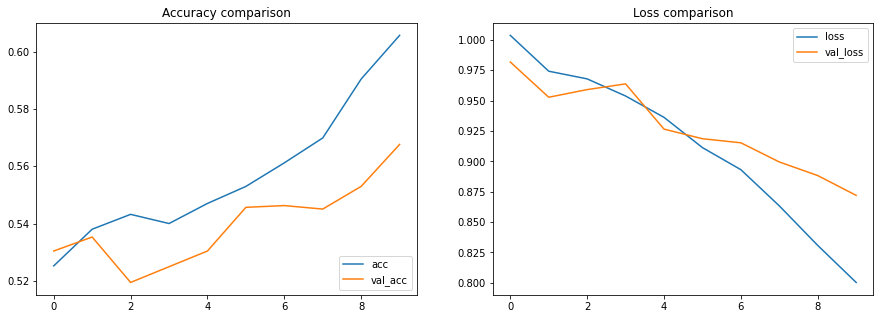

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(general.history['accuracy'], label='acc')
plt.plot(general.history['val_accuracy'], label='val_acc')
plt.legend(loc='lower right')
plt.title('Accuracy comparison')

plt.subplot(1, 2, 2)
plt.plot(general.history['loss'], label='loss')
plt.plot(general.history['val_loss'], label='val_loss')
plt.legend(loc='upper right')
plt.title('Loss comparison')

plt.show()

### CNN 증강 버전
모델, 히스토리 저장 링크
https://drive.google.com/drive/folders/1pTTZI_bfVOVXptYJ-GdtdU5HMW5geO0p?usp=sharing



```
rotation_range=0.3, zoom_range=0.3
```




In [ ]:
t = ImageDataGenerator(rescale=1./ 255, rotation_range=0.3, zoom_range=0.3)

t_gen = t.flow_from_dataframe(files_df,x_col='filepath', y_col='label', target_size = (128, 128),batch_size=16,class_mode='categorical', color_mode='rgb', subset='training')

Found 8212 validated image filenames belonging to 3 classes.


In [ ]:
#train_df, valid_df = train_test_split(files_df, test_size = 0.2, stratify = files_df['label'], random_state = 1234)
k = ImageDataGenerator(rescale=1./ 255, validation_split=0.2)
t_nongen = k.flow_from_dataframe(files_df, x_col='filepath', y_col='label', target_size = (128, 128), class_mode='categorical', color_mode='rgb', subset='training')
v_nongen = k.flow_from_dataframe(files_df, x_col='filepath', y_col='label', target_size = (128, 128), class_mode='categorical', color_mode='rgb', subset='validation')

Found 6570 validated image filenames belonging to 3 classes.
Found 1642 validated image filenames belonging to 3 classes.


In [ ]:
cnn = Sequential([
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal', input_shape=(128,128,3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(32, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(64, kernel_initializer='random_normal'),
    Activation('relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
    
])

cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        18464     
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        1

2022-11-25 12:07:30.423855: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
cnn.compile(
    'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [ ]:
verimggen = cnn.fit(t_gen, steps_per_epoch = t_gen.samples//16, validation_data= v_nongen, epochs= 10, verbose=1)
cnn.save('CNN_verimggen1.h5')

2022-11-25 12:07:41.372762: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
206/206 [==============================] - 2617s 13s/step - loss: 1.0037 - accuracy: 0.5253 - val_loss: 0.9818 - val_accuracy: 0.5305
Epoch 2/10
206/206 [==============================] - 2566s 12s/step - loss: 0.9742 - accuracy: 0.5381 - val_loss: 0.9528 - val_accuracy: 0.5353
Epoch 3/10
206/206 [==============================] - 2603s 13s/step - loss: 0.9679 - accuracy: 0.5432 - val_loss: 0.9591 - val_accuracy: 0.5195
Epoch 4/10
206/206 [==============================] - 2596s 13s/step - loss: 0.9538 - accuracy: 0.5400 - val_loss: 0.9638 - val_accuracy: 0.5250
Epoch 5/10
206/206 [==============================] - 2592s 13s/step - loss: 0.9362 - accuracy: 0.5470 - val_loss: 0.9265 - val_accuracy: 0.5305
Epoch 6/10
206/206 [==============================] - 2519s 12s/step - loss: 0.9113 - accuracy: 0.5530 - val_loss: 0.9186 - val_accuracy: 0.5457
Epoch 7/10
206/206 [==============================] - 2561s 12s/step - loss: 0.8931 - accuracy: 0.5612 - val_loss: 0.9153 - val_ac

In [ ]:
verimggen.history

{'loss': [1.003749966621399,
  0.974226176738739,
  0.9679051041603088,
  0.9538061618804932,
  0.9362174868583679,
  0.9113044738769531,
  0.8931166529655457,
  0.863330066204071,
  0.8307437896728516,
  0.8002455234527588],
 'accuracy': [0.5252663493156433,
  0.5380517244338989,
  0.5432267785072327,
  0.5400304198265076,
  0.5470319390296936,
  0.5529680252075195,
  0.561187207698822,
  0.5698630213737488,
  0.5904109477996826,
  0.6056316494941711],
 'val_loss': [0.9817997217178345,
  0.9527755379676819,
  0.9590694308280945,
  0.9637839794158936,
  0.9265195727348328,
  0.9186108708381653,
  0.9152628183364868,
  0.8994780778884888,
  0.8882761001586914,
  0.871961772441864],
 'val_accuracy': [0.5304506421089172,
  0.5353227853775024,
  0.5194884538650513,
  0.5249695777893066,
  0.5304506421089172,
  0.5456759929656982,
  0.5462850332260132,
  0.5450670123100281,
  0.5529841780662537,
  0.5676004886627197]}

In [1]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(verimggen.history['accuracy'], label='acc')
plt.plot(verimggen.history['val_accuracy'], label='val_acc')
plt.legend(loc='lower right')
plt.title('Accuracy comparison')

plt.subplot(1, 2, 2)
plt.plot(verimggen.history['loss'], label='loss')
plt.plot(verimggen.history['val_loss'], label='val_loss')
plt.legend(loc='upper right')
plt.title('Loss comparison')

plt.show()

"plt.figure(figsize=(15, 5))\n\nplt.subplot(1, 2, 1)\nplt.plot(verimggen.history['accuracy'], label='acc')\nplt.plot(verimggen.history['val_accuracy'], label='val_acc')\nplt.legend(loc='lower right')\nplt.title('Accuracy comparison')\n\nplt.subplot(1, 2, 2)\nplt.plot(verimggen.history['loss'], label='loss')\nplt.plot(verimggen.history['val_loss'], label='val_loss')\nplt.legend(loc='upper right')\nplt.title('Loss comparison')\n\nplt.show()"